# Problem Statement

## **Business Context**

A sales forecast predicts future sales revenue based on historical data, industry trends, and the status of the current sales pipeline. Businesses use the sales forecast to estimate weekly, monthly, quarterly, and annual sales totals. A company needs to make an accurate sales forecast as it adds value across an organization and helps the different verticals to chalk out their future course of action. Forecasting helps an organization plan its sales operations by region and provides valuable insights to the supply chain team regarding the procurement of goods and materials. 
An accurate sales forecast process has many benefits, which include improved decision-making about the future and the reduction of sales pipeline and forecast risks. Moreover, it helps to reduce the time spent in planning territory coverage and establishes benchmarks that can be used to assess trends in the future.

## **Objective**

They hired you as an MLOps Engineer, and your task is to build an automated MLOps pipeline with CI/CD to deliver accurate and reliable sales forecasts. The objective is to leverage historical sales data, industry trends, and the current pipeline status to predict weekly, monthly, quarterly, and annual revenues. By automating data ingestion, preprocessing, model training, evaluation, and deployment, the pipeline will ensure scalability, consistency, and minimal manual intervention. With CI/CD integration, forecasts will be continuously updated and seamlessly deployed, enabling different business verticals to plan sales operations by region, optimize supply chain procurement, reduce risks in sales pipelines, and establish benchmarks for future trend analysis. Ultimately, this solution will enhance decision-making, streamline planning efforts, and drive operational efficiency and business growth.

## **Data Description**

- **Product_Id**:Unique identifier of each product, each identifier having two letters at the beginning, followed by a number
- **Product_Weight**:Weight of each product
- **Product_Sugar_Content**:Sugar content of each product, like low sugar, regular, and no sugar
- **Product_Allocated_Area**:Ratio of the allocated display area of each product to the total display area of all the products in a store
- **Product_Type**:Broad category for each product like meat, snack foods, hard drinks, dairy, canned, soft drinks, health and hygiene, baking goods, bread, breakfast, frozen foods, fruits and vegetables, household, seafood, starchy foods, others
- **Product_MRP**:Maximum retail price of each product
- **Store_Id**:Unique identifier of each store
- **Store_Establishment_Year**:Year in which the store was established
- **Store_Size**:Size of the store, depending on sq. feet, like high, medium, and low
- **Store_Location_City_Type**:Type of city in which the store is located, like Tier 1, Tier 2, and Tier 3. Tier 1 consists of cities where the standard of living is comparatively higher than that of its Tier 2 and Tier 3 counterparts
- **Store_Type**:Type of store depending on the products that are being sold there, like Departmental Store, Supermarket Type 1, Supermarket Type 2, and Food Mart
- **Product_Store_Sales_Total**:Total revenue generated by the sale of that particular product in that particular store

# Model Building

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository
import pandas as pd
from datasets import load_dataset

## Data Registration

In [3]:
%%writefile model_building/data_register.py
from huggingface_hub.utils import RepositoryNotFoundError, HfHubHTTPError
from huggingface_hub import HfApi, create_repo
import os


repo_id = "arulmozhiselvan/superkart"
repo_type = "dataset"

# Initialize API client
api = HfApi(token=os.getenv("HF_TOKEN"))

# Step 1: Check if the space exists
try:
    api.repo_info(repo_id=repo_id, repo_type=repo_type)
    print(f"Space '{repo_id}' already exists. Using it.")
except RepositoryNotFoundError:
    print(f"Space '{repo_id}' not found. Creating new space...")
    create_repo(repo_id=repo_id, repo_type=repo_type, private=False)
    print(f"Space '{repo_id}' created.")

api.upload_folder(
    folder_path="data",
    repo_id=repo_id,
    repo_type=repo_type,
)

Overwriting model_building/data_register.py


## Data Preparation

In [22]:
%%writefile model_building/prep.py
# for data manipulation
import pandas as pd
import sklearn
# for creating a folder
import os
# for data preprocessing and pipeline creation
from sklearn.model_selection import train_test_split
# for converting text data in to numerical representation
from sklearn.preprocessing import LabelEncoder
# for hugging face space authentication to upload files
from huggingface_hub import login, HfApi
from huggingface_hub import hf_hub_download


# Define the repository ID and the filename
REPO_ID = "arulmozhiselvan/superkart" 
FILENAME = "SuperKart.csv" 
HF_TOKEN = os.getenv("HF_TOKEN")
api = HfApi(token=HF_TOKEN)

# Download the file to a local cache and get the local file path
csv_file_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME, repo_type="dataset")

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)


# Read dataset from Hugging Face
print("Superkart dataset loaded successfully.")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.drop('Product_Id', axis=1, inplace=True)
# ---------------------------
# Encode categorical columns
# ---------------------------
label_encoder = LabelEncoder()

categorical_cols = [
    'Product_Sugar_Content',
    'Product_Type',
    'Store_Id',
    'Store_Size',
    'Store_Location_City_Type',
    'Store_Type'
    ]

for col in categorical_cols:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    else:
        print(f"Warning: Column '{col}' not found in dataset")

# ---------------------------
# Target column
# ---------------------------
target_col = "Product_Store_Sales_Total"

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found")

# ---------------------------
# Train-test split
# ---------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# ---------------------------
out_dir = "data"
os.makedirs(out_dir, exist_ok=True)

Xtrain_path = f"{out_dir}/Xtrain.csv"
Xtest_path = f"{out_dir}/Xtest.csv"
ytrain_path = f"{out_dir}/ytrain.csv"
ytest_path = f"{out_dir}/ytest.csv"

Xtrain.to_csv(Xtrain_path, index=False)
Xtest.to_csv(Xtest_path, index=False)
ytrain.to_csv(ytrain_path, index=False)
ytest.to_csv(ytest_path, index=False)

print("Train-test split complete. Files saved locally:")
print(Xtrain_path, Xtest_path, ytrain_path, ytest_path)

# ---------------------------
# Upload files to Hugging Face dataset repo
# ---------------------------
files = [Xtrain_path, Xtest_path, ytrain_path, ytest_path]

for file_path in files:
    api.upload_file(
        path_or_fileobj=file_path,
        path_in_repo=os.path.basename(file_path),   # uploads just filename
        repo_id="arulmozhiselvan/superkart",
        repo_type="dataset",
    )
    print(f"Uploaded {file_path} to HF dataset repo.")


Overwriting model_building/prep.py


## Model Training and Registration with Experimentation Tracking

In [12]:
%%writefile model_building/train.py
# for data manipulation
import pandas as pd
import os
from huggingface_hub import HfApi, hf_hub_download, create_repo
from huggingface_hub.utils import RepositoryNotFoundError, HfHubHTTPError

# for data preprocessing and pipeline creation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# for model training, tuning, and evaluation
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# for model serialization
import joblib

# for MLflow logging (local file-based tracking)

# -------------------------
# Configuration / HF dataset paths
# -------------------------
# Replace HF usernames/repos if different
HF_DATASET_REPO = "arulmozhiselvan/superkart"
XTRAIN_FILENAME = "Xtrain.csv"
XTEST_FILENAME  = "Xtest.csv"
YTRAIN_FILENAME = "ytrain.csv"
YTEST_FILENAME  = "ytest.csv"

# -------------------------
# Download dataset splits from Hugging Face dataset repo (requires HF_TOKEN in env)
# -------------------------
hf_token = os.getenv("HF_TOKEN")
api = HfApi(token=hf_token)

# hf_hub_download returns local path to the file
Xtrain_path = hf_hub_download(repo_id=HF_DATASET_REPO, filename=XTRAIN_FILENAME, repo_type="dataset", token=hf_token)
Xtest_path  = hf_hub_download(repo_id=HF_DATASET_REPO, filename=XTEST_FILENAME,  repo_type="dataset", token=hf_token)
ytrain_path = hf_hub_download(repo_id=HF_DATASET_REPO, filename=YTRAIN_FILENAME, repo_type="dataset", token=hf_token)
ytest_path  = hf_hub_download(repo_id=HF_DATASET_REPO, filename=YTEST_FILENAME,  repo_type="dataset", token=hf_token)

# Read CSVs
Xtrain = pd.read_csv(Xtrain_path)
Xtest  = pd.read_csv(Xtest_path)
ytrain = pd.read_csv(ytrain_path)
ytest  = pd.read_csv(ytest_path)

# Convert y DataFrame -> Series if needed
if isinstance(ytrain, pd.DataFrame) and ytrain.shape[1] == 1:
    ytrain = ytrain.iloc[:, 0]
if isinstance(ytest, pd.DataFrame) and ytest.shape[1] == 1:
    ytest = ytest.iloc[:, 0]

print("Data loaded:")
print("Xtrain:", Xtrain.shape, "Xtest:", Xtest.shape, "ytrain:", ytrain.shape, "ytest:", ytest.shape)

# -------------------------
# Feature selection (adjust to match your dataset)
# -------------------------
numeric_features = [
    'Product_Weight',
    'Product_Allocated_Area',
    'Product_MRP',
    'Store_Establishment_Year',
    'Product_Store_Sales_Total'
    ]
numeric_features = [c for c in numeric_features if c in Xtrain.columns]

categorical_features = [c for c in [
    'Product_Sugar_Content',
    'Product_Type',
    'Store_Id',
    'Store_Size',
    'Store_Location_City_Type',
    'Store_Type'
    ] if c in Xtrain.columns]

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

# -------------------------
# Class weight to handle imbalance (guarded)
# -------------------------
pos = int(ytrain.value_counts().get(1, 0))
neg = int(ytrain.value_counts().get(0, 0))
if pos == 0 or neg == 0:
    class_weight = 1.0
else:
    class_weight = neg / pos
print("Class weight (neg/pos):", class_weight)

# -------------------------
# Preprocessing pipeline
# -------------------------
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    remainder='drop'
)

# -------------------------
# Define XGBoost model
# -------------------------
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter grid (same style as your example)
param_grid = {
    'xgbregressor__max_depth': [3, 5, 7, 10],
    'xgbregressor__n_estimators': [100, 200, 500],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2]
}

# Create pipeline
model_pipeline = make_pipeline(preprocessor, xgb_model)

# -------------------------
# Configure MLflow to use local file-based tracking (development)


# -------------------------
# Grid search with cross-validation and MLflow logging
# -------------------------

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5)
grid_search.fit(Xtrain, ytrain)

# Best model
best_model = grid_search.best_estimator_
print("Best Params:\n", grid_search.best_params_)

# Predict on training set
y_pred_train = best_model.predict(Xtrain)

# Predict on test set
y_pred_test = best_model.predict(Xtest)

# Save best model locally
model_filename = "best_model_v1.joblib"
joblib.dump(best_model, model_filename)
print("Model saved as", model_filename)


# -------------------------
# Upload saved model to Hugging Face Model Hub (new model repo)
# -------------------------
repo_id = "arulmozhiselvan/superkart-model"
repo_type = "model"

api = HfApi(token=os.getenv("HF_TOKEN"))

# Step 1: Check if the model repo exists
try:
    api.repo_info(repo_id=repo_id, repo_type=repo_type)
    print(f"Model repo '{repo_id}' already exists. Using it.")
except RepositoryNotFoundError:
    print(f"Model repo '{repo_id}' not found. Creating new model repo...")
    create_repo(repo_id=repo_id, repo_type=repo_type, private=False, token=os.getenv("HF_TOKEN"))
    print(f"Model repo '{repo_id}' created.")

# Upload the model file
try:
    api.upload_file(
        path_or_fileobj=model_filename,
        path_in_repo=model_filename,
        repo_id=repo_id,
        repo_type=repo_type,
        token=os.getenv("HF_TOKEN"),
    )
    print(f"Uploaded {model_filename} to {repo_id}")
except HfHubHTTPError as e:
    print("Failed to upload model to Hugging Face:", str(e))

print("Training script finished.")

Overwriting model_building/train.py


# Deployment

## Dockerfile

In [13]:
%%writefile deployment/Dockerfile
# Use a minimal base image with Python 3.9 installed
FROM python:3.9

# Set the working directory inside the container to /app
WORKDIR /app

# Copy all files from the current directory on the host to the container's /app directory
COPY . .

# Install Python dependencies listed in requirements.txt
RUN pip3 install -r requirements.txt

RUN useradd -m -u 1000 user
USER user
ENV HOME=/home/user \
	PATH=/home/user/.local/bin:$PATH

WORKDIR $HOME/app

COPY --chown=user . $HOME/app

# Define the command to run the Streamlit app on port "8501" and make it accessible externally
CMD ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0", "--server.enableXsrfProtection=false"]

Overwriting deployment/Dockerfile


## Streamlit App

Please ensure that the web app script is named `app.py`.

In [17]:
%%writefile deployment/app.py
import streamlit as st
import pandas as pd
from huggingface_hub import hf_hub_download
import joblib
import os

# -------------------------
# Configuration
# -------------------------
HF_MODEL_REPO = "arulmozhiselvan/superkart-model"
MODEL_FILENAME = "best_model_v1.joblib"

# -------------------------
# Download & load model
# -------------------------
model = None
try:
    model_path = hf_hub_download(repo_id=HF_MODEL_REPO, filename=MODEL_FILENAME, repo_type="model", token=os.getenv("HF_TOKEN"))
    model = joblib.load(model_path)
    st.write(f"Loaded model from Hugging Face: {HF_MODEL_REPO}/{MODEL_FILENAME}")
except Exception as e:
    st.warning(f"Could not download model from Hugging Face ({HF_MODEL_REPO}).\nError: {e}\nFalling back to local file if present.")
    if os.path.exists(MODEL_FILENAME):
        model = joblib.load(MODEL_FILENAME)
        st.write(f"Loaded local model file: {MODEL_FILENAME}")
    else:
        st.error("Model not available. Please upload the model to HF or place it locally.")
        st.stop()

# -------------------------
# Streamlit UI
# -------------------------
st.title("SuperKart Sales Prediction App")
st.write("Predict product sales at different stores using trained ML model.")

# --- Customer details
Product_Weight = st.number_input("Product Weight", value=12.66)
Product_Sugar_Content = st.selectbox("Sugar Content", ["Low Sugar","No Sugar","Medium Sugar","High Sugar"])
Product_Allocated_Area = st.number_input("Allocated Area", value=0.027, step=0.001, format="%.3f")
Product_Type = st.text_input("Product Type", "Frozen Foods")
Product_MRP = st.number_input("Product MRP", value=117.08)
Store_Id = st.text_input("Store Id", "OUT004")
Store_Establishment_Year = st.number_input("Store Establishment Year", value=2009, step=1)
Store_Size = st.selectbox("Store Size", ["Small", "Medium", "High"])
Store_Location_City_Type = st.selectbox("Store City Type", ["Tier 1", "Tier 2", "Tier 3"])
Store_Type = st.text_input("Store Type", "Supermarket Type2")


# Assemble input into DataFrame matching training columns (raw — pipeline should handle preprocessing)
input_df = pd.DataFrame([{
    "Product_Weight": Product_Weight,
    "Product_Sugar_Content": Product_Sugar_Content,
    "Product_Allocated_Area": Product_Allocated_Area,
    "Product_Type": Product_Type,
    "Product_MRP": Product_MRP,
    "Store_Id": Store_Id,
    "Store_Establishment_Year": Store_Establishment_Year,
    "Store_Size": Store_Size,
    "Store_Location_City_Type": Store_Location_City_Type,
    "Store_Type": Store_Type
}])

st.subheader("Input Preview")
st.dataframe(input_df.T, width=700)

# Prediction
if st.button("Predict Purchase Probability"):
    prediction = model.predict(input_df)
    st.subheader("Prediction Result")
    st.write(f"Predicted Product Store Sales Total: {prediction[0]:.2f}")

Overwriting deployment/app.py


## Dependency Handling

Please ensure that the dependency handling file is named `requirements.txt`.

In [18]:
%%writefile deployment/requirements.txt
pandas==2.2.2
huggingface_hub==0.32.6
streamlit==1.43.2
joblib==1.5.1
scikit-learn==1.6.0
xgboost==2.1.4


Overwriting deployment/requirements.txt


# Hosting

In [20]:
# %%writefile hosting/hosting.py
from huggingface_hub import HfApi
import os

# Authenticate using your HF_TOKEN (must be added in GitHub Actions secrets OR env vars)
api = HfApi(token=os.getenv("HF_TOKEN"))

# Upload the entire Streamlit deployment folder to your Hugging Face Space
api.upload_folder(
    folder_path="deployment",         # local folder containing app.py + requirements.txt
    repo_id="arulmozhiselvan/superkart-app",  # 🚨 your HF Space name
    repo_type="space",                            # this is a Streamlit Space
    path_in_repo=""                               # upload to root of the Space
)

print("Deployment files uploaded successfully to Hugging Face Space!")

Deployment files uploaded successfully to Hugging Face Space!


# MLOps Pipeline with Github Actions Workflow

**Note:**

1. Before running the file below, make sure to add the HF_TOKEN to your GitHub secrets to enable authentication between GitHub and Hugging Face.
2. The below code is for a sample YAML file that can be updated as required to meet the requirements of this project.

```
name: Superkart prediction workflow

on:
  push:
    branches:
      - main  # Automatically triggers on push to the main branch

jobs:

  register-dataset:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Install Dependencies
        run: pip install -r requirements.txt
      - name: Upload Dataset to Hugging Face Hub
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python model_building/data_register.py

  data-prep:
    needs: register-dataset
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Install Dependencies
        run: pip install -r requirements.txt
      - name: Run Data Preparation
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python model_building/prep.py


  model-traning:
    needs: data-prep
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Install Dependencies
        run: pip install -r requirements.txt
      - name: Model Building
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python model_building/train.py


  deploy-hosting:
    runs-on: ubuntu-latest
    needs: [model-traning,data-prep,register-dataset]
    steps:
      - uses: actions/checkout@v3
      - name: Install Dependencies
        run: pip install -r requirements.txt
      - name: Push files to Frontend Hugging Face Space
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python hosting/hosting.py

```

**Note:** To use this YAML file for our use case, we need to

1. Go to the GitHub repository for the project
2. Create a folder named ***.github/workflows/***
3. In the above folder, create a file named ***pipeline.yml***
4. Copy and paste the above content for the YAML file into the ***pipeline.yml*** file

## Requirements file for the Github Actions Workflow

In [21]:
%%writefile requirements.txt
huggingface_hub==0.32.6
datasets==3.6.0
pandas==2.2.2
scikit-learn==1.6.0
xgboost==2.1.4

Overwriting requirements.txt


## Github Authentication and Push Files

* Before moving forward, we need to generate a secret token to push files directly from Colab to the GitHub repository.
* Please follow the below instructions to create the GitHub token:
    - Open your GitHub profile.
    - Click on ***Settings***.
    - Go to ***Developer Settings***.
    - Expand the ***Personal access tokens*** section and select ***Tokens (classic)***.
    - Click ***Generate new token***, then choose ***Generate new token (classic)***.
    - Add a note and select all required scopes.
    - Click ***Generate token***.
    - Copy the generated token and store it safely in a notepad.

# Output Evaluation

- GitHub (link to repository, screenshot of folder structure and executed workflow)

Link to repo - https://github.com/arul-mozhi-selvan/tourism-gl

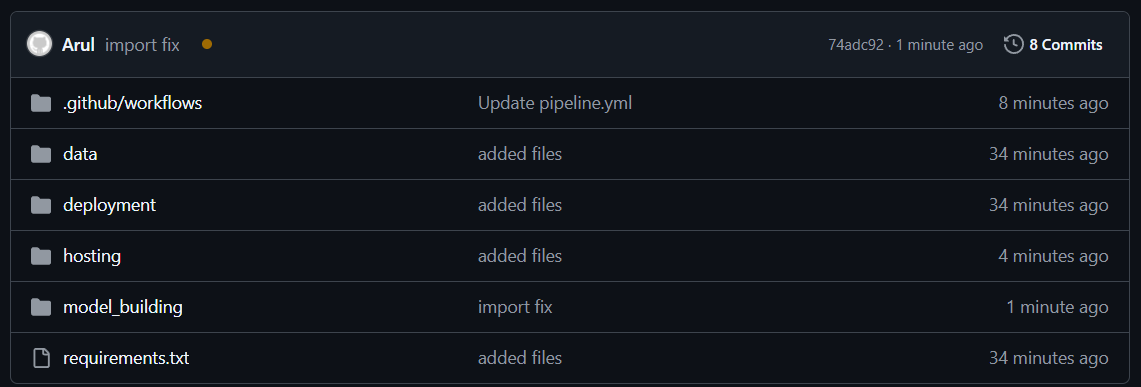

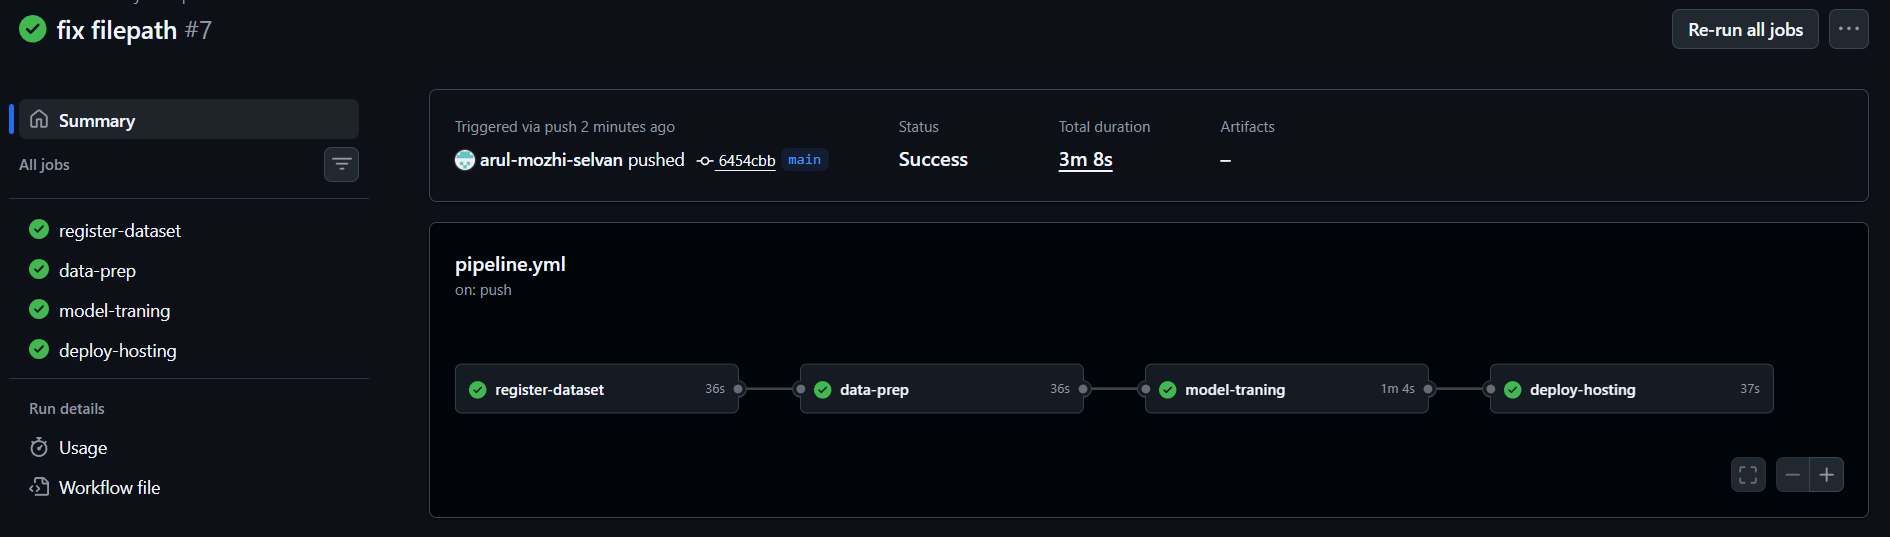

- Streamlit on Hugging Face (link to HF space, screenshot of Streamlit app)

Link to HF space - https://huggingface.co/spaces/arulmozhiselvan/tourism-gl

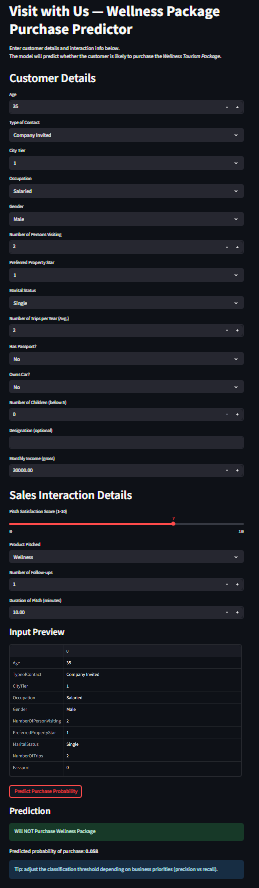

<font size=6 color="navyblue">Power Ahead!</font>
___